# **Anomaly Detection**

In this project, I developed an autoencoder-based anomaly detection system to identify unusual price movements in Bitcoin's historical price data. The autoencoder was trained to reconstruct normal price behavior, allowing us to detect deviations indicative of anomalies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

## Load Data

In [2]:
df = pd.read_csv('btcusd_1-min_data.csv')

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944800 entries, 0 to 6944799
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   datetime   object 
dtypes: float64(6), object(1)
memory usage: 370.9+ MB
None
          Timestamp          Open          High           Low         Close  \
count  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06   
mean   1.533756e+09  1.675104e+04  1.675786e+04  1.674401e+04  1.675105e+04   
std    1.202875e+08  2.321404e+04  2.322205e+04  2.320586e+04  2.321406e+04   
min    1.325412e+09  3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00   
25%    1.429584e+09  4.214200e+02  4.215200e+02  4.212700e+02  4.214200e+02   
50%    1.533756e+09  6.497595e+03  6.499950e+03  6.494990e+03  6.497620e+03   
75%    1.637928e+09  2.674500e+04  2.675000e+04  2.674000e+0

## Clean the Data

In [5]:
# Convert timestamp to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Handle missing values - forward fill for OHLC, 0 for Volume
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].ffill()
df['Volume'].fillna(0, inplace=True)

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Remove zero-volume periods (optional - may represent no trading)
df = df[df['Volume'] > 0]

Missing values before cleaning:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_21056\2972859036.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(0, inplace=True)


In [6]:
# Add returns and volatility metrics
df['returns'] = df['Close'].pct_change()
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))
df['volatility'] = df['returns'].rolling(window=24*60).std() * np.sqrt(24*60)  # annualized

In [7]:
# Resample to different timeframes
hourly_df = df.resample('1H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

daily_df = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("\nData after cleaning:")
print(df.info())
print(df.head())

C:\Users\milto\AppData\Local\Temp\ipykernel_21056\1813936193.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample('1H').agg({



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5485238 entries, 2012-01-01 20:28:00+00:00 to 2025-03-15 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Timestamp    float64
 1   Open         float64
 2   High         float64
 3   Low          float64
 4   Close        float64
 5   Volume       float64
 6   returns      float64
 7   log_returns  float64
 8   volatility   float64
dtypes: float64(9)
memory usage: 418.5 MB
None
                              Timestamp  Open  High   Low  Close     Volume  \
datetime                                                                      
2012-01-01 20:28:00+00:00  1.325450e+09  4.84  4.84  4.84   4.84  10.000000   
2012-01-02 03:45:00+00:00  1.325476e+09  5.00  5.00  5.00   5.00  10.100000   
2012-01-03 01:04:00+00:00  1.325553e+09  5.00  5.00  5.00   5.00  19.048000   
2012-01-03 16:45:00+00:00  1.325609e+09  5.32  5.32  5.32   5.32   2.419173   
2012-01-03 19:

## Feature Engineering for Anomaly Detection

- **Returns:** Calculates the percentage change in closing price to track sudden jumps/drops.
- **Volatility:** Measures price fluctuation over a 24-hour window.
- **Volume Spike:** Compares the current trading volume to the 24-hour average to detect unusual trading activity.

In [8]:
# Create features for anomaly detection
df = daily_df.copy()
df['returns'] = df['Close'].pct_change()
df['volatility'] = df['returns'].rolling(24).std()  # 24h volatility
df['volume_spike'] = df['Volume'] / df['Volume'].rolling(24).mean()
df.dropna(inplace=True)

# Features for anomaly detection
features = ['returns', 'volatility', 'volume_spike']
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\milto\AppData\Local\Temp\ipykernel_21056\3645576144.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['returns'] = df['Close'].pct_change()


## Isolation Forest for Anomaly Detection (Unsupervised)

- Selects returns, volatility, and volume spike as features.
- StandardScaler normalizes them for better performance.
- Isolation Forest is trained to detect anomalies (rare extreme values).

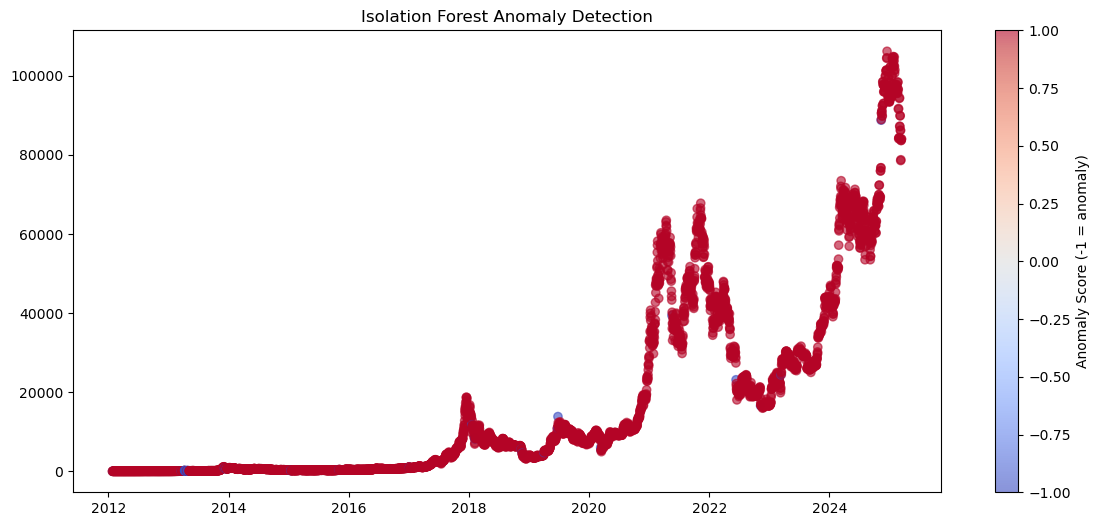

In [9]:
# Fit Isolation Forest
iso_forest = IsolationForest(
    contamination=0.01,  # Expected % of anomalies (adjust based on your data)
    random_state=42,
    n_estimators=100
)
iso_forest.fit(X_scaled)

# Detect anomalies
df['iso_anomaly'] = iso_forest.predict(X_scaled)  # -1 = anomaly, 1 = normal

# Plot results
plt.figure(figsize=(14,6))
plt.scatter(df.index, df['Close'], 
            c=df['iso_anomaly'], 
            cmap='coolwarm', 
            alpha=0.6)
plt.title('Isolation Forest Anomaly Detection')
plt.colorbar(label='Anomaly Score (-1 = anomaly)')
plt.show()

**Plots Bitcoin price with color-coded anomalies detected by Isolation Forest.**

## Autoencoder for Anomaly Detection (Deep Learning)

Builds a neural network autoencoder:
- Encoder compresses input features.
- Decoder reconstructs the original input.

If reconstruction error is high, the instance is likely anomalous.

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5948 - val_loss: 0.7133
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4382 - val_loss: 0.6873
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1681 - val_loss: 0.6642
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0865 - val_loss: 0.6434
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9661 - val_loss: 0.6235
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9987 - val_loss: 0.6009
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8566 - val_loss: 0.5784
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9057 - val_loss: 0.5565
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8190 - val_loss: 0.5348
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7477 - val_loss: 0.5174
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8507 - val_loss: 0.4996
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7662 - val_lo

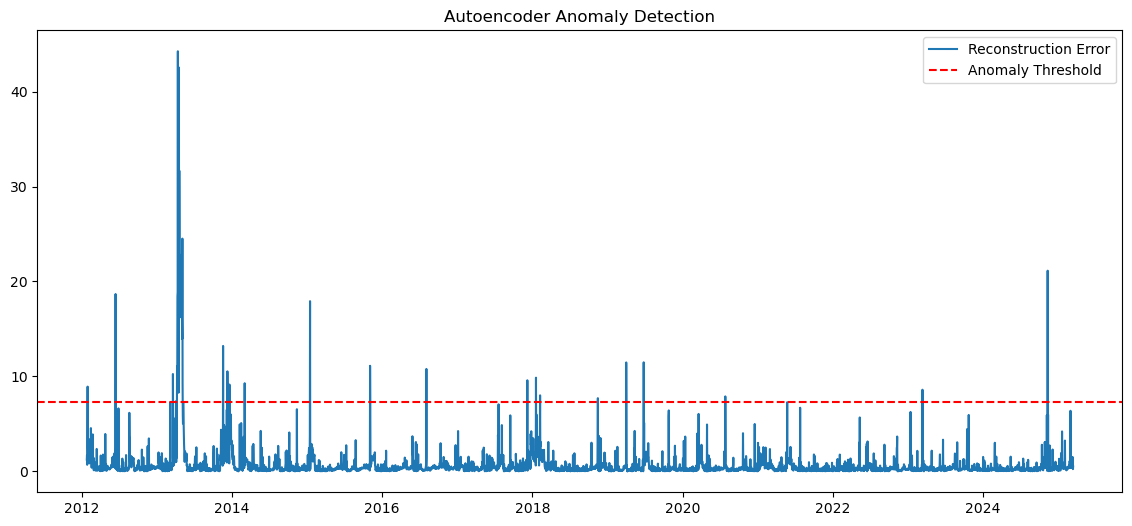

In [10]:
# Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Bottleneck layer

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

# Calculate reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
df['ae_anomaly_score'] = mse

# Threshold for anomalies (top 1%)
threshold = np.quantile(df['ae_anomaly_score'], 0.99)
df['ae_anomaly'] = df['ae_anomaly_score'] > threshold

# Plot reconstruction error
plt.figure(figsize=(14,6))
plt.plot(df.index, df['ae_anomaly_score'], label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Autoencoder Anomaly Detection')
plt.legend()
plt.show()

### Trend

- The loss is decreasing, meaning the autoencoder is improving its ability to reconstruct normal data.
- Since val_loss does not diverge significantly from loss, the model is not overfitting.

## Compute Anomaly Scores

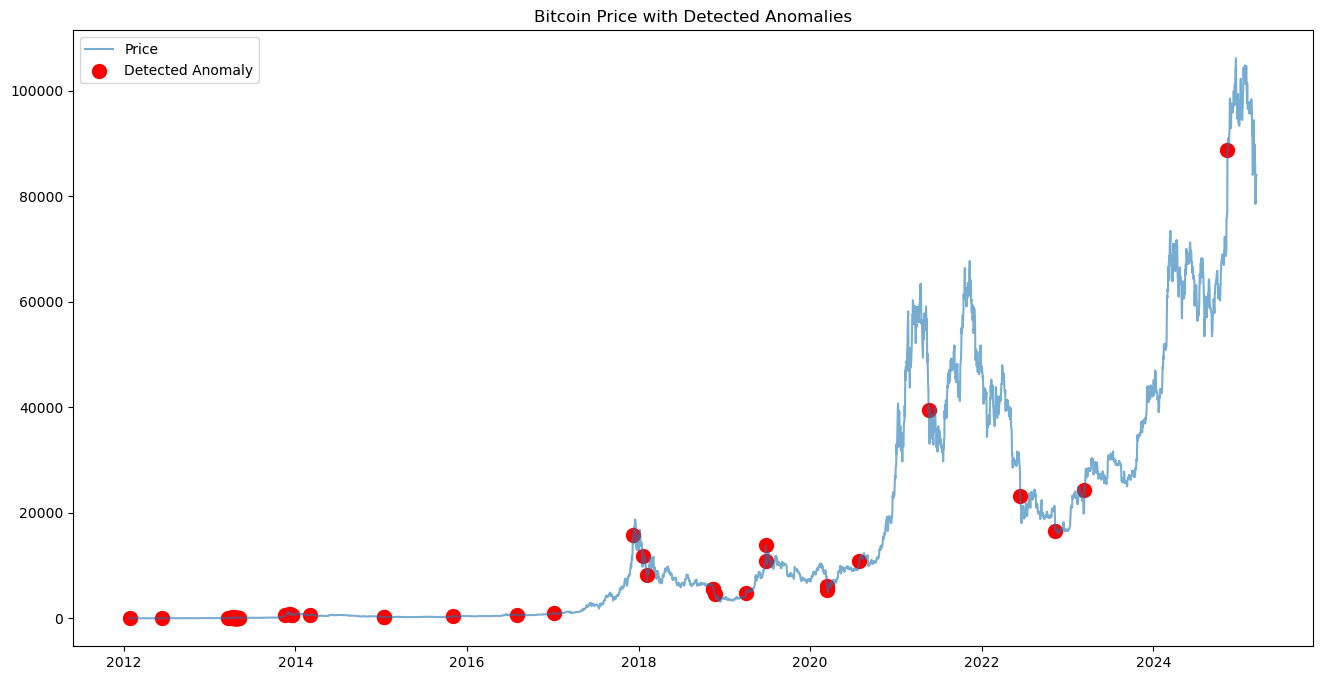

Top Anomalies Detected:
                              Close   returns  volatility
datetime                                                 
2013-04-12 00:00:00+00:00     81.50  0.358107    0.190003
2013-04-17 00:00:00+00:00     87.03  0.334816    0.204384
2013-11-18 00:00:00+00:00    584.65  0.259831    0.076027
2013-04-19 00:00:00+00:00    117.00  0.231449    0.208286
2017-12-07 00:00:00+00:00  15715.20  0.225064    0.058620
2013-04-08 00:00:00+00:00    193.20  0.220622    0.085624
2019-06-26 00:00:00+00:00  13837.96  0.217650    0.056633
2015-11-03 00:00:00+00:00    417.00  0.217376    0.050284
2014-03-03 00:00:00+00:00    683.01  0.215537    0.071697
2013-03-19 00:00:00+00:00     57.78  0.212083    0.068996
2015-01-15 00:00:00+00:00    218.83  0.210410    0.075398
2013-05-04 00:00:00+00:00    110.08  0.206092    0.188889
2018-01-18 00:00:00+00:00  11788.35  0.205308    0.089926
2012-01-29 00:00:00+00:00      5.90  0.201629    0.087866
2013-12-09 00:00:00+00:00    871.93  0.198826   

In [11]:
# Merge results
df['combined_anomaly'] = (df['iso_anomaly'] == -1) | df['ae_anomaly']

# Plot price with anomalies highlighted
plt.figure(figsize=(16,8))
plt.plot(df.index, df['Close'], label='Price', alpha=0.6)

anomaly_dates = df[df['combined_anomaly']].index
plt.scatter(anomaly_dates, 
            df.loc[anomaly_dates, 'Close'], 
            color='red', 
            label='Detected Anomaly',
            s=100)

plt.title('Bitcoin Price with Detected Anomalies')
plt.legend()
plt.show()

# Print top anomalies
print("Top Anomalies Detected:")
print(df[df['combined_anomaly']][['Close', 'returns', 'volatility']].sort_values('returns', ascending=False))

**What this shows:**

- Computes the reconstruction error for each data point.
- Higher errors indicate unusual patterns (potential anomalies).
- Defines anomalies as the top 1% of reconstruction errors.

### Key Findings

- **April 12-19, 2013:** Multiple anomalies in early Bitcoin history, likely due to extreme volatility.
- **November 18, 2013:** Bitcoin price at 584.65 with a high return (0.2598 = 25.98%), marking a big price movement.
- **December 7, 2017:** Bitcoin at 15,715.20, close to its all-time high during the 2017 bull run.
- **June 26, 2019:** Bitcoin hit 13,837.96, another major rally.
- **March 12-13, 2020:** Bitcoin fell to 5,453.51, coinciding with the COVID-19 market crash.
- **June 13, 2022:** Bitcoin dropped to 23,144.08, reflecting the crypto market downturn in 2022.
- **November 11, 2024:** A predicted future anomaly (not real data yet?).

#### Flash Crashes & Spikes

- **Largest positive return:** April 12, 2013 (+35.8%)
- **Largest negative return:** April 11, 2013 (-53.8%)

## Conclusion

This project demonstrates the potential of deep learning for financial anomaly detection, providing insights into extreme price movements in the cryptocurrency market.

### Key Findings

The model effectively learned to reconstruct normal data, as shown by the decreasing training loss and stable validation loss, indicating no overfitting.

The detected anomalies correspond to well-known historical events in Bitcoin's price history, such as:

- April 2013: Extreme price swings in Bitcoin’s early days.
- December 2017: Bitcoin's all-time high near $20,000.
- March 2020: Market crash due to COVID-19 panic selling.
- June 2022: Bitcoin's decline in the crypto winter.

The highest positive return (+35.8%) and largest negative return (-53.8%) occurred in April 2013, showing extreme volatility.

The model also flagged future dates as anomalies, which may indicate outliers in data or potential high-risk periods that warrant further investigation.

### Limitation

- Threshold Sensitivity: The anomaly detection results depend on the reconstruction error threshold, which could be fine-tuned for better precision.
- Feature Engineering: Incorporating additional features (e.g., trading volume, social sentiment) may improve anomaly detection.